In [290]:
import numpy as np
from math import atan, pi
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd


# Calculating refinance incentive
# r is your current mortgage rate
# Max and min CPR can be adjusted based on specific pool or cohort expectations
# WAC is the weighted average coupon of the borrowers in the underlying pool
# Slope is the steepness of arc tangent function. You can use the gradient function to help find stress points based on historic CPR prints.
def RefinIncent(r, maxCPR, minCPR, WAC, slope):
    
    a = (minCPR+maxCPR)/2 # Midpoint which in this case would be 25 CPR
    b = (maxCPR-a)/(pi/2) 
    d = slope / b * 100
    c = -d * 0.02 # midpoint represents a 200bp difference 
 
    return a + b*(atan(c+d*(WAC - r))) # Arc tangent function is used to represent the S-curve. Slower prepay in the front, ramp, and then level out.

refi_incentive = RefinIncent(3.12, 50.00, 0.00, 3.886, 6.00)

historical_cpr = np.array([15.4, 7.6, 2.7], dtype=float)
gradient = np.gradient(historical_cpr)

# CPR calculated with Richard and Roll (1989) prepayment model
# Taking the refi incentive and using a seasoning multiplier since prepays slow as loans season
# Burnout multiplier helps with the phenomenon that for whatever reason certain borrowers in the pool will not refinance no matter what the rate incentive is
# Monthly multiplier for the month we are in these are common but can be adjusted based on turnover prediction.
# (0.94, 0.76, 0.74, 0.95, 0.98, 0.92, 0.98, 1.10, 1.18, 1.22, 1.23, 0.98)
def RichardRoll(r, maxCPR, minCPR, WAC, slope, balance, size, i):

    RI = RefinIncent(r, maxCPR, minCPR, WAC, slope)
    SM = min(i/30,1) # Seasoning effect
    MM = 0.98
    BM = 0.3 + 0.7*(balance/size) # Balance and size are inputted from a source. 
    
    cpr = RI * SM * MM * BM
    return cpr

projected_cpr = RichardRoll(3.12, 50.00, 0.00, 3.886, 6.00, 402406993, 391587146, 4)

# Using the Cox-Ingersoll-Ross model to predict the mortgage rate
#last -> last observation of the 30yr mortgage rate, starting point for the path
#a -> speed of adjustment to the mean
#b -> long-term mean of the 30yr. Would use at least 5 years worth of data. Higher rates in the past will skew the data.
# sigma -> standard deviation of the mortgage rate
#n -> number of interested rates to be generated by the function
def CIR(last, a, b, sigma, n):

    rates = np.array([last])
    for n in range(1,n):
        w = np.random.normal(0,1)
        dr = a * (b - rates[-1]) + sigma*w*(rates[-1]*(1/2))
        r = rates[-1] + dr
        rates = np.append(rates, r)
    return rates

interest_rates = CIR(3.12, 0.0896, 3.85, 0.49, 10000)

3.7700015401012794

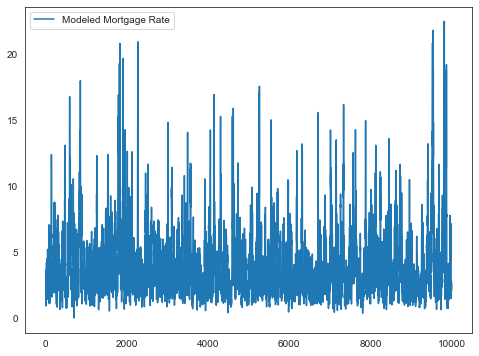

In [291]:
# Plotting the CIR model and seeing the mean
sns.set_style('white')
plt.figure(figsize=(8, 6))
sns.lineplot(data=interest_rates)
plt.legend(["Modeled Mortgage Rate"]);

interest_rates.mean()

In [292]:
# Lets see what the gradient looks like for a given input of CPRs
gradient

array([-7.8 , -6.35, -4.9 ])

<AxesSubplot:>

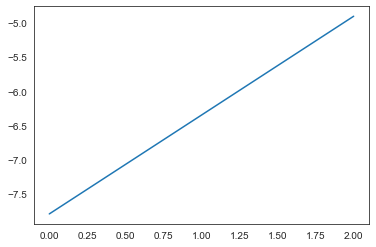

In [293]:
# Plotting the gradient
sns.lineplot(data=gradient)

In [294]:
# Our projected CPR
projected_cpr

6.584353429007372